In [1]:


import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import helper
from torch.utils import data
from datasets import BerkeleyDataSet, BerkeleyDataTestSet

resize_input_to = [1280,720]
data_root = 'data\\bdd100k';
list_root = os.path.join(data_root, 'lists\\100k\\drivable');

train_dataset = BerkeleyDataSet(data_root, os.path.join(list_root, 'train_images.txt'), resize_to=resize_input_to);
val_dataset = BerkeleyDataSet(data_root, os.path.join(list_root, 'val_images.txt'), resize_to=resize_input_to, train=False);

print(len(train_dataset), len(val_dataset))

train_loader = data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=1, pin_memory=True)
val_loader = data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=1)

7000 900


In [2]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss
from matplotlib import pyplot as plt

def calc_loss(pred, target, metrics, bce_weight=0.5):
    #bce = F.binary_cross_entropy_with_logits(pred, target)
        
    #pred = F.sigmoid(pred)
    #dice = dice_loss(pred, target)
    
    #loss = bce * bce_weight + dice * (1 - bce_weight)
    pred = pred.type(torch.FloatTensor)
    target = target.type(torch.LongTensor)
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
    loss = loss_fn(pred, target)
    
    #metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    #metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, epoch, best_loss, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        since = time.time()
        loader = train_loader;

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                loader = val_loader;
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for i, batch in enumerate(loader):
                input_images, target_masks, _, _ = batch
                
                inputs = input_images.to(device)
                labels = target_masks.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)
            
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model with loss: ", epoch_loss)
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [3]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import unet_pytorch
import gc

load_from_checkpoint = True
learn_gen = None
gc.collect()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 19
if load_from_checkpoint:
    model = unet_pytorch.UNet(n_channels=3, n_classes=num_class)
    optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)
    checkpoint = torch.load('model/checkpoint.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
else:
    model = unet_pytorch.UNet(n_channels=3, n_classes=num_class).to(device)
    optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)
    epoch = 0
    loss = 1e10

cuda:0


In [ ]:
### TRAIN MODEL 

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, epoch, loss, num_epochs=10)

(1, 3, 720, 1280) (1, 19, 720, 1280) (1, 720, 1280)
(720, 1280, 3) (720, 1280) (720, 1280)


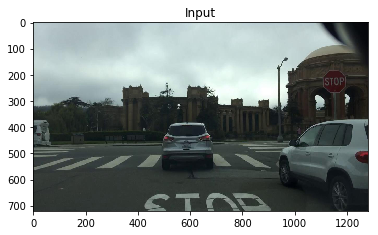

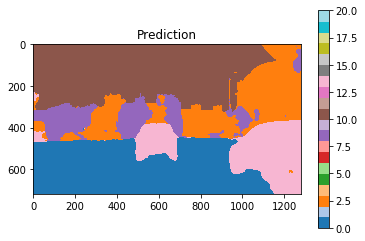

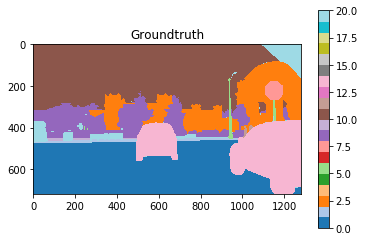

In [12]:
# prediction

import math
from matplotlib.colors import Normalize
import matplotlib

model.eval()   # Set model to evaluate mode

test_dataset = BerkeleyDataTestSet(data_root, os.path.join(list_root, 'test_images.txt'), resize_to=resize_input_to);
test_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=1)
        
inputs, labels, _, _ = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
imgs = inputs.data.cpu().numpy()
labels = labels.data.cpu().numpy()
print(imgs.shape, pred.shape, labels.shape)

# Map each channel (i.e. class) to each color
target_masks_rgb = [x for x in labels]
pred_rgb = [np.argmax(x, axis=0) for x in pred]
input_images_rgb = [helper.format_network_input_as_image(x) for x in imgs]

print(input_images_rgb[0].shape, pred_rgb[0].shape, target_masks_rgb[0].shape)

plt.imshow(input_images_rgb[0])
plt.title("Input")
plt.show()
plt.imshow(pred_rgb[0], cmap=plt.get_cmap('tab20'), vmin=0, vmax=20)
plt.title("Prediction")
plt.colorbar()
plt.show()
target_masks_rgb[0][target_masks_rgb[0] == 255] = 20
plt.imshow(target_masks_rgb[0], cmap=plt.get_cmap('tab20'), vmin=0, vmax=20)
plt.title("Groundtruth")
plt.colorbar()
plt.show()